<a href="https://colab.research.google.com/github/samiksha261/Tensorflow-File/blob/main/15_seq_to_vector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras


In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [4]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

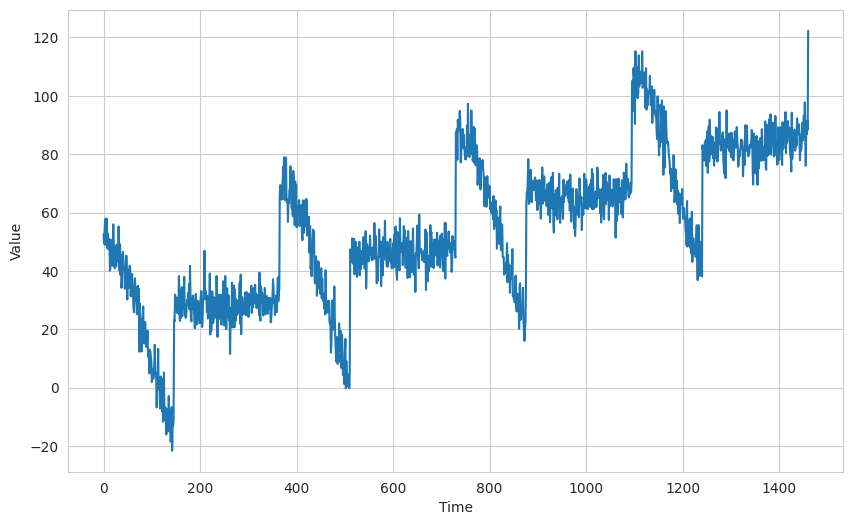

In [5]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [6]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [8]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [9]:
train_set = window_dataset(X_train,window_size,batch_size=128)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
train_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [11]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences= True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])

In [12]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 100)         10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [13]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/20))

In [14]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [15]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 246ms/step - loss: 167.5492 - mae: 168.0492 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 65ms/step - loss: 132.0528 - mae: 132.5524 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 51ms/step - loss: 77.1125 - mae: 77.6124 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 49ms/step - loss: 34.3841 - mae: 34.8801 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 1s 57ms/step - loss: 41.5428 - mae: 42.0414 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 1s 55ms/step - loss: 38.9989 - mae: 39.4968 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 33ms/step - loss: 30.7979 - mae: 31.2947 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 1s 48ms/step - loss: 22.3003 - mae: 22.7930 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 49ms/step - loss: 19.1554 - mae: 19.6487 - lr

(1e-07, 0.0001, 0.0, 30.0)

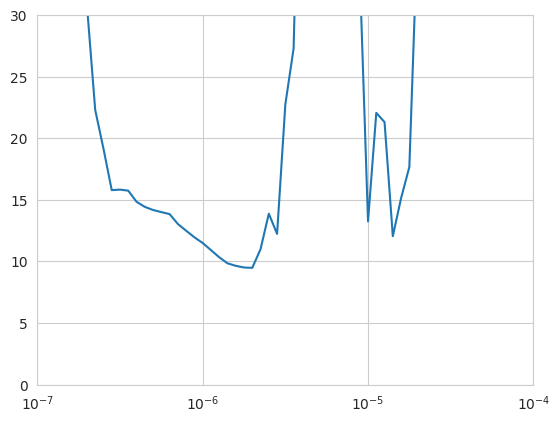

In [16]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,1e-4,0,30])


In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size,batch_size=128)
valid_set = window_dataset(X_valid,window_size,batch_size=128)

In [18]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [19]:
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [20]:

early_stopping = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",
                                                  save_best_only=True)

In [21]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 3s 86ms/step - loss: 20.4442 - mae: 20.9417 - val_loss: 22.2702 - val_mae: 22.7686
Epoch 2/500
8/8 [==============================] - 0s 57ms/step - loss: 26.5813 - mae: 27.0790 - val_loss: 8.5083 - val_mae: 8.9898
Epoch 3/500
8/8 [==============================] - 0s 41ms/step - loss: 24.9540 - mae: 25.4507 - val_loss: 11.4567 - val_mae: 11.9473
Epoch 4/500
8/8 [==============================] - 1s 64ms/step - loss: 53.0051 - mae: 53.5047 - val_loss: 26.4365 - val_mae: 26.9365
Epoch 5/500
8/8 [==============================] - 1s 67ms/step - loss: 48.2827 - mae: 48.7822 - val_loss: 19.9686 - val_mae: 20.4664
Epoch 6/500
8/8 [==============================] - 1s 53ms/step - loss: 39.7208 - mae: 40.2196 - val_loss: 37.3209 - val_mae: 37.8201
Epoch 7/500
8/8 [==============================] - 0s 41ms/step - loss: 11.9464 - mae: 12.4322 - val_loss: 9.4948 - val_mae: 9.9817


In [22]:
model = keras.models.load_model("my_checkpoint.h5")

In [23]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:

rnn_forecast = model_forcast(model,series[split_time-window_size:-1],window_size)[:,0]

15/15 [==============================] - 1s 14ms/step


9.114

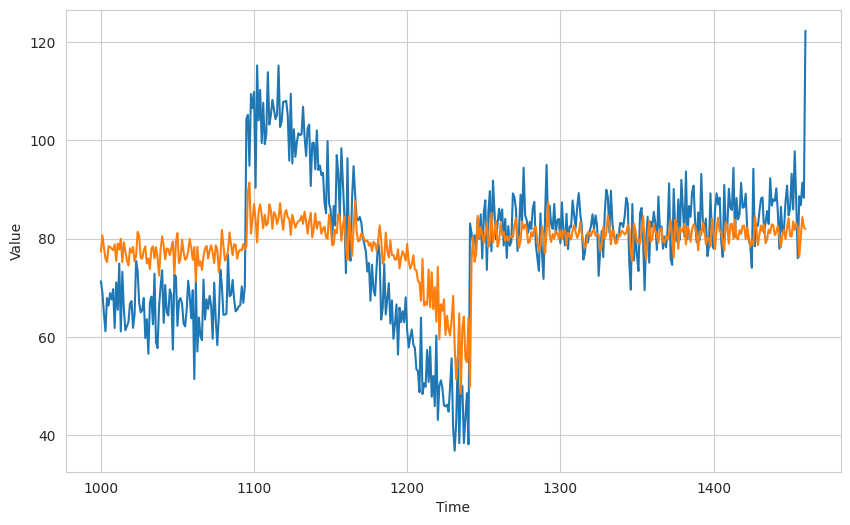

In [25]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)
print('\n')
keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy()

In [27]:
#Sequence_to_Sequence

In [28]:
def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [29]:
for X_batch,Y_batch in seq2_seq_window_dataset(tf.range(10),3,batch_size=1):
    print("X : ",X_batch.numpy())
    print("Y : ",Y_batch.numpy())

X :  [[[4]
  [5]
  [6]]]
Y :  [[[5]
  [6]
  [7]]]
X :  [[[1]
  [2]
  [3]]]
Y :  [[[2]
  [3]
  [4]]]
X :  [[[0]
  [1]
  [2]]]
Y :  [[[1]
  [2]
  [3]]]
X :  [[[5]
  [6]
  [7]]]
Y :  [[[6]
  [7]
  [8]]]
X :  [[[2]
  [3]
  [4]]]
Y :  [[[3]
  [4]
  [5]]]
X :  [[[6]
  [7]
  [8]]]
Y :  [[[7]
  [8]
  [9]]]
X :  [[[3]
  [4]
  [5]]]
Y :  [[[4]
  [5]
  [6]]]


In [30]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [31]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [32]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [33]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/30))

In [34]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [35]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 30ms/step - loss: 107.6211 - mae: 108.1209 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 64.4207 - mae: 64.9192 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 36.1740 - mae: 36.6710 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 38.4365 - mae: 38.9341 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 31.3539 - mae: 31.8501 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 29.2100 - mae: 29.7060 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 29ms/step - loss: 26.5206 - mae: 27.0152 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 24.8010 - mae: 25.2958 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 25ms/step - loss: 23.4191 - mae: 23.9125 - lr: 1

(1e-07, 0.0001, 0.0, 30.0)

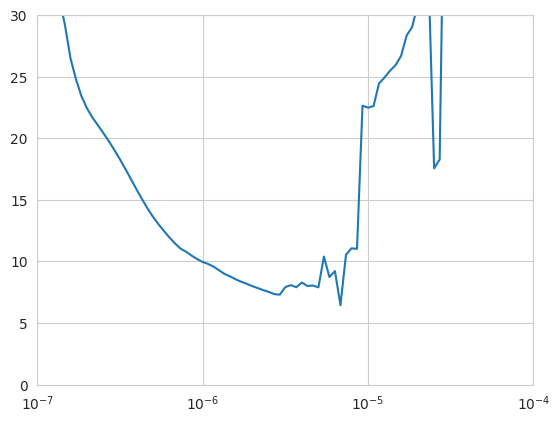

In [36]:
plt.semilogx(history.history['lr'],history.history["loss"])
plt.axis([1e-7,1e-4,0,30])

In [37]:
# Second
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [38]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [39]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [40]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [41]:
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 93ms/step - loss: 83.8568 - mae: 84.3558 - val_loss: 33.0775 - val_mae: 33.5762
Epoch 2/500
8/8 [==============================] - 0s 42ms/step - loss: 51.2506 - mae: 51.7487 - val_loss: 87.8530 - val_mae: 88.3530
Epoch 3/500
8/8 [==============================] - 0s 45ms/step - loss: 34.4340 - mae: 34.9312 - val_loss: 33.6384 - val_mae: 34.1373
Epoch 4/500
8/8 [==============================] - 0s 42ms/step - loss: 23.5680 - mae: 24.0628 - val_loss: 20.5766 - val_mae: 21.0732
Epoch 5/500
8/8 [==============================] - 0s 45ms/step - loss: 16.9721 - mae: 17.4642 - val_loss: 16.4332 - val_mae: 16.9266
Epoch 6/500
8/8 [==============================] - 0s 43ms/step - loss: 12.9340 - mae: 13.4238 - val_loss: 10.8935 - val_mae: 11.3823
Epoch 7/500
8/8 [==============================] - 1s 52ms/step - loss: 11.3167 - mae: 11.8038 - val_loss: 10.1433 - val_mae: 10.6282
Epoch 8/500
8/8 [==============================] - 0s 42ms/ste

In [42]:
rnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

45/45 [==============================] - 19s 9ms/step


In [43]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

5.533133




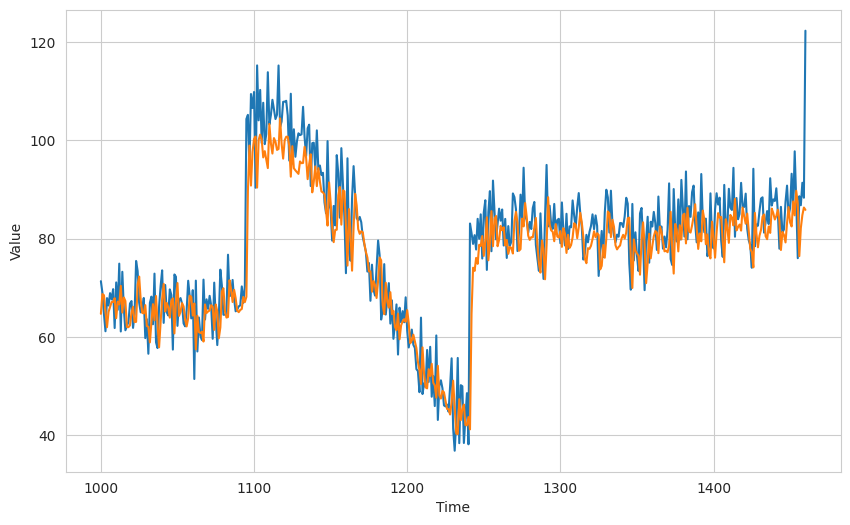

In [44]:
print(keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy())
print('\n')
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

StateFull RNN

In [45]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [46]:
for X_batch,Y_batch in sequential_window_dataset(tf.range(10),3):
    print(X_batch.numpy(),Y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [47]:
class RestStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [48]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [49]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)

In [50]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [51]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/30))

In [52]:
reset_states = RestStatesCallback()

In [53]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [54]:
history = model.fit(train_set,epochs=100,
                   callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 2s 9ms/step - loss: 13.3284 - mae: 13.8151 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 13.3258 - mae: 13.8154 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 12.8601 - mae: 13.3496 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 12.7753 - mae: 13.2600 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 8ms/step - loss: 12.6546 - mae: 13.1395 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 12.5856 - mae: 13.0698 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 8ms/step - loss: 12.5390 - mae: 13.0237 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 8ms/step - loss: 12.5085 - mae: 12.9940 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 8ms/step - loss: 12.4852 - mae: 12.9704 

In [55]:
#model = keras.models.load_model("my_checkpoint.h5")
#model.reset_states()
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])
rnn_forecast = rnn_forecast[0, split_time -1 :-1, 0]

1/1 [==============================] - 0s 420ms/step


In [56]:
rnn_forecast.shape

(461,)

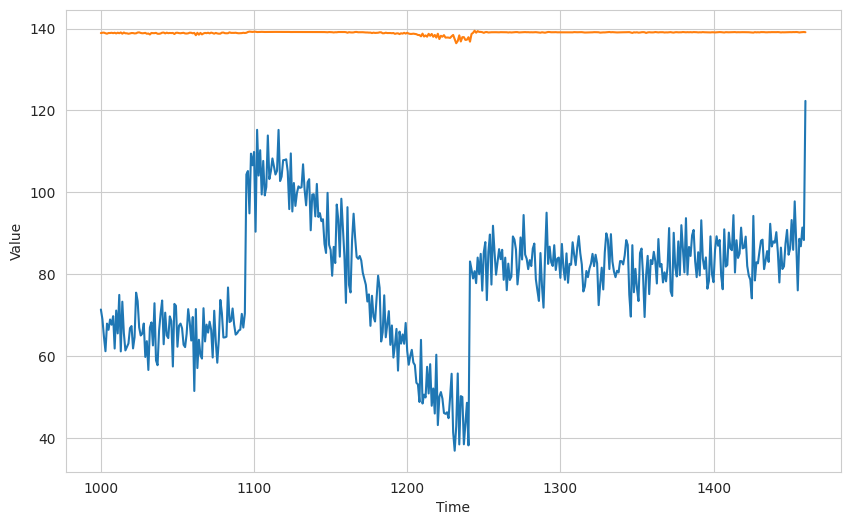

In [57]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)